In [46]:
import numpy as np
import random
from matplotlib import pyplot as plt
from tqdm import trange

In [47]:
def game_over(game_board):
    if np.max(np.sum(game_board, axis=1)) == 3:
        return True, 1

    elif np.max(np.sum(game_board, axis=0)) == 3:
        return True, 1
    
    elif np.trace(game_board) == 3:
        return True, 1

    elif np.min(np.sum(game_board, axis=1)) == -3:
        return True, -1

    elif np.min(np.sum(game_board, axis=0)) == -3:
        return True, -1

    elif np.trace(game_board) == -3:
        return True, -1
    
    elif np.count_nonzero(game_board) == 9:
        return True, 0

    return False , 0

In [1]:
class AI:
    def __init__(self, epsilon, player, learning_rate):
        self.q_table = {}
        self.epsilon = epsilon
        self.learning_rate = learning_rate
        self.player = player

    def q_table_update(self, board_state):
        if len(self.q_table[0]) == 0:
            self.q_table[0].append(board_state)
            self.q_table[1].append(self.possible_moves(board_state))
            return 0

        for i in range(len(self.q_table[0])):
            if np.array_equal(self.q_table[0][i], board_state):
                return i
            else:
                self.q_table[0].append(board_state)
                self.q_table[1].append(self.possible_moves(board_state))
                return i+1

    def possible_moves(self, board_state):
        moves = []
        for i in range(3):
            for j in range(3):
                if board_state[i][j] == 0:
                    moves.append(0)
                else:
                    moves.append(-100)#'NaN')
        possible_moves = np.array([[moves[0],moves[1],moves[2]],[moves[3],moves[4],moves[5]],[moves[6],moves[7],moves[8]]], dtype = float)
        return possible_moves

    def possible_random_moves(self, board_state):
        moves = []
        for i in range(3):
            for j in range(3):
                if board_state[i][j] != -100:
                    moves.append(3*i + j)
        return moves

    def move(self, board_state, state):
        if random.random() < self.epsilon: 
            return np.argmax(self.q_table[1][state])
        else:
            return random.choice(self.possible_random_moves(self.q_table[1][state]))

    def update_reward(self, old_state, new_board_state, move, game_over, result):

        if game_over:
            #print('Game Over')
            delta = self.q_table[1][old_state].flatten()[move] + self.learning_rate * (self.q_table[1][old_state].flatten()[move] + result - self.q_table[1][old_state].flatten()[move])
            #print(delta)
        else:
            for i in range(len(self.q_table[0])):
                if np.array_equal(self.q_table[0][i], new_board_state):
                    #print('Exist')
                    delta = self.q_table[1][old_state].flatten()[move] + self.learning_rate * (self.q_table[1][old_state].flatten()[move] + self.q_table[1][i].flatten()[move] - self.q_table[1][old_state].flatten()[move])
                else:
                    #print('Dont exist')
                    delta = self.q_table[1][old_state].flatten()[move] + self.learning_rate * (self.q_table[1][old_state].flatten()[move] + 0 - self.q_table[1][old_state].flatten()[move])
              
        #print('move', move)
        temp = self.q_table[1][old_state].flatten()
        temp[move] = delta
        #print(delta)
        #print('delta', delta)
        self.q_table[1][old_state] = temp.reshape((3,3))
        #print(self.q_table[1][old_state])

In [49]:
class tictactoe:
    def __init__(self):
        self.board_state = np.zeros((3,3), dtype=int)

    def get_board_state(self):
        return self.board_state
    
    def update_board_state(self, move, player):
        temp = self.board_state.flatten()
        temp[move] = player
        self.board_state = temp.reshape((3,3))

In [50]:
def training_round(player1, player2):

    board = tictactoe()
    
    # Get the board_state
    board_state = board.get_board_state()

    first = False
    game_status = False
    
    win1, win2 , draw = 0, 0, 0

    while True:

        # Update player1 q_table with the board_state and return the state
        state1 = player1.q_table_update(board_state)

        # Make a epislon move and return the move
        move1 = player1.move(board_state, state1)

        # Update the board_state
        board.update_board_state(move1, player1.player)

        # Get the board_state
        board_state = board.get_board_state()
       
        game_status, result = game_over(board_state)
        
        if first:
            player2.update_reward(state2, board_state, move2, game_status, -result)

        first == True

        if game_status:
            player1.update_reward(state1, board_state, move1, game_status, result)
            if result == 1:
                win1 = 1
                return win1, win2, draw
            if result == -1:
                win2 = 1
                return win1, win2, draw
            if result == 0:
                draw = 1
                return win1, win2, draw


        # Update player2 q_table with the board_state and return the state
        state2 = player2.q_table_update(board_state)
        
        # Make a epislon move and return the move
        move2 = player2.move(board_state, state2)

        # Update the board_state
        board.update_board_state(move2, player2.player)

        # Get the board_state
        board_state = board.get_board_state()

        game_status, result = game_over(board_state)

        player1.update_reward(state1, board_state, move1, game_status, result)

        if game_status:
            player2.update_reward(state2, board_state, move2, game_status, -result)
            if result == 1:
                win1 = 1
                return win1, win2, draw
            if result == -1:
                win2 = 1
                return win1, win2, draw
            if result == 0:
                draw = 1
                return win1, win2, draw

In [59]:
np.set_printoptions(suppress=True)


board = tictactoe()

player1 = AI(epsilon = epsilon, player = 1, learning_rate = learning_rate)
player2 = AI(epsilon = epsilon, player = -1, learning_rate = learning_rate)

win_1 = []
win_2 = []
draws = []

n_games = 500
for i in trange(n_games):
    win1, win2, draw = training_round(player1, player2)
    win_1.append(win1)
    win_2.append(win2)
    draws.append(draw)



0
100
200
300
400


50 0 0


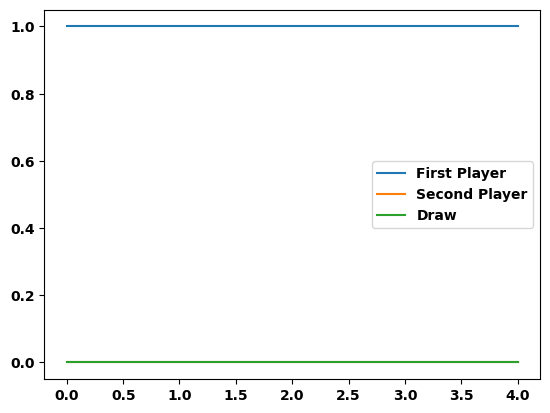

In [52]:
print(np.sum(win_1), np.sum(win_2), np.sum(draws))

win_rate_1 = np.mean(np.array(win_1).reshape(-1, int(n_games/5)), axis = 1)
win_rate_2 = np.mean(np.array(win_2).reshape(-1, int(n_games/5)), axis = 1)
win_rate_draw = np.mean(np.array(draws).reshape(-1, int(n_games/5)), axis = 1)

plt.plot(win_rate_1, label = 'First Player')
plt.plot(win_rate_2, label = 'Second Player')
plt.plot(win_rate_draw, label = 'Draw')
plt.legend()
plt.show()

In [53]:
len(player1.q_table[1])

130

In [60]:
player1.q_table[1][0]

array([[-250. ,  -68.4, -100. ],
       [-100. , -100. , -100. ],
       [-100. , -100. , -100. ]])

In [58]:
player1.q_table[0][0]


array([[ 1, -1,  1],
       [ 0,  0,  0],
       [ 0,  0,  0]])

In [56]:
#np.savetxt("win_1.csv", player1.q_table[1], fmt='%s')